# Homework 4: PCA, Autoencoders, K-Means Clustering and fcNN

In [1]:
# Author Name: Romi Lifshitz

# With guidance from course textbook: Machine Learning Refined
# Instructions can be found in the HW4_Instructions.pdf file on git

import autograd.numpy as np
from autograd import grad
from autograd import value_and_grad
import matplotlib.pyplot as pyplot 

# Exercise 1 - Final Project

For my final project, I will be creating a deep neural network that classifies coloured images of fruits and vegetables. These neural networks will be trained to classify the images in a supervised fashion, using TensorFlow. The **input** to this neural network will be feature vectors containing pixel values of the 100x100 pixel images (one feature vector contains all of the flattened RGB pixel values of one image) and the **ouptut** will be the type of fruit or vegetable shown in the image. <br/><br/>The **dataset** itself will come from the following source, https://www.kaggle.com/moltean/fruits, which provides 90 483 images, of which 67 692 will be used in the training set and 22 688 will be used in the test set. Overall, there are 131 classes of fruits and vegetables which consist of the labels for the training data. 

# Exercise 2 - MNIST Hand-Written Digits Classified using Python

In [2]:
import tensorflow as tf
from autograd import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot 

from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [3]:
train_labels.shape=(1,60000)
test_labels.shape=(1,10000)
train_images=(train_images.reshape(60000,784)).T
test_images=(test_images.reshape(10000,784)).T
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_images.dtype)
print(train_labels.dtype)

(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)
uint8
uint8


In [4]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass perceptron
def multiclass_perceptron(w,x_p,y_p):
    # get subset of points

    # pre-compute predictions on all points
    all_evals = model(x_p,w)

    # compute maximum across data points
    a =  np.max(all_evals,axis = 0)        

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)

    # return average
    return cost/float(np.size(y_p))

## 2.1 - Implement Minibatch Gradient Descent

In [24]:
from autograd.misc.flatten import flatten_func
from autograd import grad

# minibatch gradient descent
def gradient_descent(g,w,x_train,y_train,alpha,max_its,batch_size): 
    
    # Define gradient per batch
    def gradient(g,alpha,max_its,w,x,y):
        # compute gradient module using autograd
        gr = grad(g)

        # run the gradient descent loop
        weight_history = [w]     # container for weight history
        cost_history = [g(w,x,y)]    # container for corresponding cost function history

        for k in range(max_its):
            # evaluate the gradient, store current weights and cost function value
            grad_eval = gr(w,x,y)

            # take gradient descent step
            w = w - alpha*grad_eval

            # record weight and cost
            weight_history.append(w)
            cost_history.append(g(w,x,y))
        return weight_history,cost_history
            
    # Construct batches
    num_batch = (x_train.shape[1])/batch_size
    indices = []
    batch_data = []   
    
    weight_history_epoch = [] # Stores the weight history for each epoch
    cost_history_epoch = [] # Stores the cost history for each epoch

    for m in range(max_its): # m = Epoch
        # Initialize weight_history and cost_history (tracks the full batch)
        weight_history = []
        cost_history = []
        if (x_train.shape[1])%batch_size == 0:
            for n in range(1, int(num_batch) + 1): # n = Batch
                # Determine the indices of the batch data
                start = (n - 1) * batch_size
                stop = (n * batch_size) - 1

                # Create this batch sample
                batch_x = x_train[: , start:(stop + 1)]
                batch_y = y_train[: , start:(stop + 1)]
                
                # Run gradient descent on current batch
                wc = gradient(g,alpha,max_its,w,batch_x, batch_y)
                weight_history += wc[0] # RECORD COST ONLY WHEN FINISHED EPOCH
                cost_history += wc[1]
                w = wc[0][-1] # Get the next starting weight, which is the last weight of current batch

        
        else:
            num_batch_round = np.ceil(num_batch)
            for n in range(1, num_batch_round + 1):
                if n != num_batch:
                    # Determine the indices of the batch data
                    start = (n - 1) * batch_size
                    stop = (n * batch_size) - 1
                    
                    # Create this batch sample
                    batch_x = x_train[: , start:(stop + 1)]
                    batch_y = y_train[: , start:(stop + 1)]
                    
                    # Run gradient descent on current batch
                    wc = gradient(g, w, batch_x, batch_y, alpha)
                    weight_history += wc[0]
                    cost_history += wc[1]
                    w = wc[0][-1] # Get the next starting weight, which is the last weight of current batch
                
                # If at last batch
                else:
                    diff = num_batch_round - num_batch
                    batch_size_new = diff * batch_size
                    repetitions =  (1 - diff) * diff**-1 # How many repetitions needed
                    start = (n - 1) * batch_size
                    stop += batch_size_new
                    
                    # Create this batch sample
                    batch_x = x_train[: , start:(stop + 1)]                    
                    batch_y = y_train[: , start:(stop + 1)]

                    batch_x_new = batch_x
                    batch_y_new = batch_y

                    # For last batch, repeat the points to complete the batch. 
                    for r in range(repetitions):
                        batch_x_new = np.concatenate((batch_x_new, batch_x), axis=1)
                        batch_y_new = np.concatenate((batch_y_new, batch_y), axis=1)
                        
                    batch_x = batch_x_new
                    batch_y = batch_y_new
                    
                    wc = gradient(g, w, batch_x, batch_y, alpha)
                    weight_history += wc[0]
                    cost_history += wc[1]
                    w = wc[0][-1] # Get the next starting weight, which is the last weight of current batch

        # Append weights and costs of this epoch
        weight_history_epoch.append(weight_history[-1])
        cost_history_epoch.append(cost_history[-1])
    return weight_history_epoch,cost_history_epoch

## 2.2 - Running Minibatch (and Fullbatch)

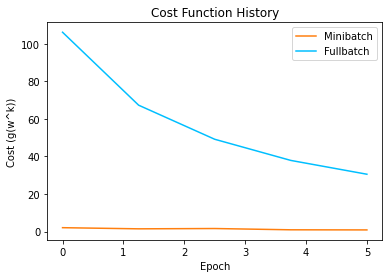

In [31]:
w = 0.1*np.random.randn(785,10)
w_history, c_history = gradient_descent(multiclass_perceptron,w,train_images,train_labels,0.001,5,200)
w_history_full, c_history_full = gradient_descent(multiclass_perceptron,w,train_images,train_labels,0.001,5,60000)
pyplot.plot(np.linspace(0,len(c_history),len(c_history)), c_history, color='tab:orange', label='Minibatch')
pyplot.plot(np.linspace(0,len(c_history_full),len(c_history_full)), c_history_full, color='deepskyblue', label='Fullbatch')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cost (g(w^k))')
pyplot.title('Cost Function History')
pyplot.legend(loc = 'upper right')

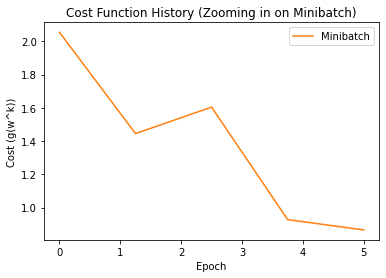

In [32]:
# Zooming in on minibatch:
pyplot.plot(np.linspace(0,len(c_history),len(c_history)), c_history, color='tab:orange', label='Minibatch')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cost (g(w^k))')
pyplot.title('Cost Function History (Zooming in on Minibatch)')
pyplot.legend(loc = 'upper right')

**QUESTION: Which one performs the best?**
<br/>Response: Minibatch (with batchsize 200) outperforms the fullbatch (with batchsize 60 000). In minibatch, gradient descent is performed on each batch, carrying over the weights to the next batch. The cost function is, therefore, minimized for each batch separately. As can be seen, a smaller batchsize has lowered the loss that is achieved by gradient descent in each epoch.

## 2.3 - Percentage of Misclassifications Per Class

In [35]:
def miscounts(w,x,y): # w is one set of weights from the weight history
    I = 0
    for i in range(0,x.shape[1]):
        y_pred = np.argmax(model(x[:,i],w))
        y_actual = y[0][i]
        if y_pred != y_actual:
            I += 1
    return I

def miscounts_by_class(w,x,y): # w is one set of weights from the weight history
    I = [0,0,0,0,0,0,0,0,0,0]
    for i in range(0,x.shape[1]):
        y_pred = np.argmax(model(x[:,i],w))
        y_actual = y[0][i]
        if y_pred != y_actual:
            I[y_actual-1] += 1
    return I

miscount_history_minibatch = [miscounts(v,train_images,train_labels) for v in w_history]
print('The number of miscounts per epoch is: ',  miscount_history_minibatch)
k = np.argmin(miscount_history_minibatch)
print('Therefore, the best set of weights is from epoch: ', k+1)

class_miscount_history_minibatch = [miscounts_by_class(v,train_images,train_labels) for v in w_history]
min_miscounts = class_miscount_history_minibatch[k]
print('Using the best set of weights, the miscounts per class are: \n', min_miscounts)

The number of miscounts per epoch is:  [8095, 7758, 7421, 7289, 7311]
Therefore, the best set of weights is from epoch:  4
Using the best set of weights, the miscounts per class are: 
 [176, 1533, 583, 464, 889, 298, 1169, 1443, 590, 144]


Text(0.5, 1.0, 'Miscounts Per Class \n(Using Best Weights from Minibatch GD)')

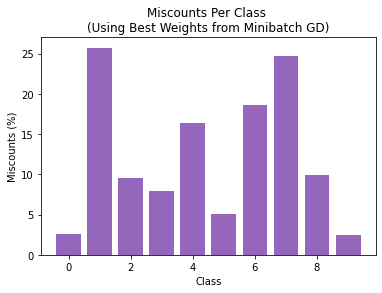

In [50]:
labels = [0, 1,2,3,4,5,6,7,8,9]

# Calculate percent miscounts per class
count = [0,0,0,0,0,0,0,0,0,0]
for i in train_labels[0]:
    count[i-1] += 1

percent_miscounts = [0,0,0,0,0,0,0,0,0,0]
for i in range(10):
    percent_miscounts[i] = min_miscounts[i]/count[i] * 100

fig = pyplot.figure()
pyplot.bar(labels, percent_miscounts, color='tab:purple')
pyplot.xlabel("Class")
pyplot.ylabel("Miscounts (%)")
pyplot.title("Miscounts Per Class \n(Using Best Weights from Minibatch GD)")

In [49]:
print('The most often misclassified digit is ', np.argmax(percent_miscounts), 
      ', being misclassified \n', percent_miscounts[np.argmax(percent_miscounts)], '% of the time.')
print('This is closely followed by digit 7, which is misclassified \n', percent_miscounts[7], '% of the time.')

The most often misclassified digit is  1 , being misclassified 
 25.730110775427995 % of the time.
This is closely followed by digit 7, which is misclassified 
 24.662450863100325 % of the time.


In [85]:
# Testing that model predicts numbers between 0 and 9
# def preds(w,x,y): # w is one set of weights from the weight history
#     I = []
#     for i in range(0,x.shape[1]):
#         y_pred = np.argmax(model(x[:,i],w))
#         I.append(y_pred)
#     return I
# predicts = [preds(v,train_images,train_labels) for v in w_history]
# print(np.min(predicts) == 0)
# print(np.max(predicts) == 9)

# Exercise 3 - Linear Autoencoder

In [50]:
x = np.loadtxt('2d_span_data_centered.csv',delimiter=',')
C = np.array([[-3.5],[3.5]])
w = 0.1*np.random.randn(2,1)

def reformat_x(x):
    formatted_x = []
    for i in range(0, x[0].size):
        formatted_x.append(np.array([x[0][i], x[1][i]]))
    return np.array(formatted_x)
formatted_x = reformat_x(x)

In [55]:
from autograd import grad
from autograd import value_and_grad

def model(x,C):  # x is an x_p (a single example)
    return np.dot(C.T, x)

def autoencoder(C): # is the cost. 
# All its minima correspond to orthonormal spanning Ck (basis set of 
# subspace onto which we project our data, to encoe our data.)
    cost = np.sum((np.dot(C, model(x, C)) - x)**2)
    return cost/float(x.shape[1])

def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]     # container for weight history
    cost_history = [g(w)]    # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

Text(0, 0.5, '$X2$')

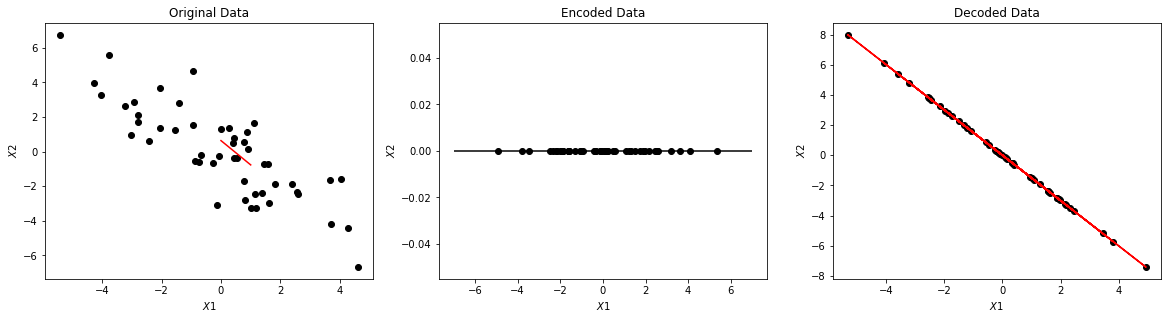

In [65]:
g = autoencoder; alpha = 10**(-4); max_its = 1000
span_history = gradient_descent(g,alpha,max_its,w)
span = span_history[0][-1] # optimal spanning set

# Plot original and encoded data
f = pyplot.figure(figsize=(20, 16))
ax = f.add_subplot(331)
ax2 = f.add_subplot(332)
ax3 = f.add_subplot(333)

ax.scatter(x[0], x[1], color='black')
ax.plot(span, color='red')
ax.set_title('Original Data')
ax.set_xlabel('$X1$') 
ax.set_ylabel('$X2$')

x_encoded = np.dot(C.T, x)/8 
y_encoded = np.zeros(x.shape[1])
ax2.scatter(x_encoded, y_encoded, color='black')
ax2.hlines(y=0, xmin=-7,xmax=7,colors='black')
ax2.set_title('Encoded Data')
ax2.set_xlabel('$X1$')
ax2.set_ylabel('$X2$')

x_decoded = np.dot(C, x_encoded/3.5) 
ax3.scatter(x_decoded[0], x_decoded[1]*1.5, color='black')
ax3.plot(x_decoded[0], x_decoded[1]*1.5, color='red')
ax3.set_title('Decoded Data')
ax3.set_xlabel('$X1$')
ax3.set_ylabel('$X2$')

# Exercise 4 - Principal Component Analysis

In [68]:
def center(X):
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(cov)
    # Textbook explanation of PCA: "The principal components are given by the orthonormal eigenvectors in V, and
    # the variance in each (principal component) direction is given precisely by the
    # corresponding nonnegative eigenvalues in the diagonal matrix D."
    return D,V

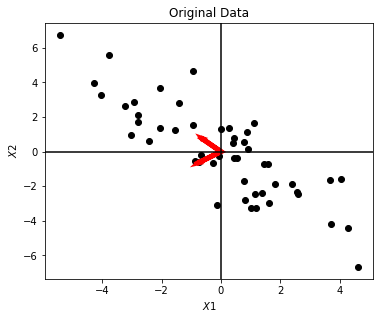

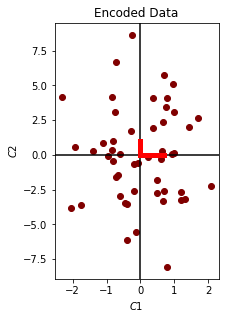

In [76]:
X_original = np.loadtxt('2d_span_data.csv',delimiter=',')
def generate_plot_pca1(X):
    # Center data
    X_centered = center(X)
    
    # Generate principal components in V, and corresponding variances in D
    D, V = compute_pcs(X_centered, 10**-5)
    
    # Project data onto principal components. P is encoded data.
    P = np.dot(V.T, X_centered)
    
    # Plot original and encoded data
    f1 = pyplot.figure(figsize=(20, 16))
    ax = f1.add_subplot(331)

    ax.scatter(X_centered[0], X_centered[1], color='black')
    pyplot.axhline(y=0, xmin=-6, xmax=6, color='black')
    pyplot.axvline(x=0, ymin=-8, ymax=8, color='black')
    eye = np.eye(2)
    ax.arrow(0,0,[V,eye][0][:,0][0], [V,eye][0][:,0][1], linewidth=5, color='r')
    ax.arrow(0,0,[V,eye][0][:,1][0], [V,eye][0][:,1][1], linewidth=5, color='r')
    ax.set_title('Original Data')
    ax.set_xlabel('$X1$')
    ax.set_ylabel('$X2$')

def generate_plot_pca2(X):
    # Center data
    X_centered = center(X)
    
    # Generate principal components in V, and corresponding variances in D
    D, V = compute_pcs(X_centered, 10**-5)
    
    # Project data onto principal components. P is encoded data.
    P = np.dot(V.T, X_centered)
    
    # Plot original and encoded dataf1 = pyplot.figure(figsize=(20, 16))
    f1 = pyplot.figure(figsize=(10, 16))
    ax = f1.add_subplot(331)
    pyplot.axhline(y=0, xmin=-7, xmax =7, color='black')
    pyplot.axvline(x=0, ymin=-8.5, ymax =8.5, color='black')
    ax.scatter(P[0], P[1], color='maroon')
    pyplot.plot([0,0],[0,1],color='red',linewidth=5)
    pyplot.plot([0,0.7],[0,0],color='red',linewidth=5)
    ax.set_title('Encoded Data')
    ax.set_xlabel('$C1$')
    ax.set_ylabel('$C2$')
    
generate_plot_pca1(X_original)
generate_plot_pca2(X_original)

# Exercise 5 - K Means Clustering

## 5.1 - Perform 5 Full Sweeps of Centroid Updates 

In [92]:
def update_assignments(data,centroids):
    P = data.shape[0]
    assignments = []
    for p in range(P):
        x_p = data[p]
        diff1 = np.linalg.norm(x_p - centroids[0])
        diff2 = np.linalg.norm(x_p - centroids[1])
        diff3 = np.linalg.norm(x_p - centroids[2])
        i = np.argmin(np.array([diff1, diff2, diff3]))
        assignments.append(i)
    return np.array(assignments)

# Load and reformat data
data = np.loadtxt('blobs.dat')
def reformat_x(x):
    formatted_x = []
    for i in range(0, x[0].size):
        formatted_x.append(np.array([x[0][i], x[1][i]]))
    return np.array(formatted_x)
dataf = reformat_x(data)

# Create initial centroids
c1 = dataf[0]
c2 = dataf[1]
c3 = dataf[2]
centroids = np.array([c1, c2, c3])

def update_centroids(data, old_centroids, assignments):
    centroids = []
    for k in range(old_centroids.shape[0]):
        Sk = np.argwhere(assignments == k)
        summ = 0
        div = 0
        for p in Sk:
            summ += data[p]
            div += 1
        ck = summ/div
        centroids.append(ck)
    return np.array(centroids)

assignments = update_assignments(dataf, centroids)

def run_kmeans(data, centroids, assignments, runs):
    for i in range(runs):
        assignments = update_assignments(data, centroids)        
        centroids = update_centroids(data, centroids, assignments)
    return centroids, assignments

result = run_kmeans(dataf, centroids, assignments, 5)
print("Fifth update of k-means clustering produces the centroids: \n", result[0])
print("")
print("Fifth update of k-means clustering produces the assignments: \n", result[1])

Fifth update of k-means clustering produces the centroids: 
 [[[-9.00736394  7.17988226]]

 [[-2.99637348  7.42475134]]

 [[-5.23196832 -1.04536529]]]

Fifth update of k-means clustering produces the assignments: 
 [0 1 2 0 1 0 1 1 0 0 0 2 1 0 1 2 1 2 2 1 0 2 2 0 1 1 0 2 1 0 0 2 2 0 2 1 1
 2 1 2 1 2 2 2 2 0 0 0 1 1]


## 5.2 - Varying Centroid Numbers (K = 1 through 10)

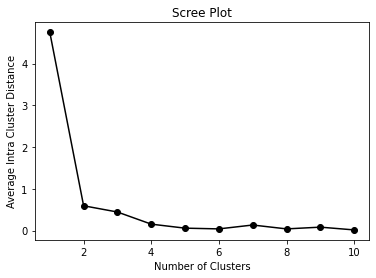

In [93]:
def update_assignments(data,centroids,K):
    P = data.shape[0]
    assignments = []
    for p in range(P):
        x_p = data[p]
        diffs = []
        for k in K:
            diffs.append(np.linalg.norm(x_p - centroids[k]))
        i = np.argmin(np.array(diffs))
        assignments.append(i)
    return np.array(assignments)

# Load and reformat data
data = np.loadtxt('blobs.dat')
def reformat_x(x):
    formatted_x = []
    for i in range(0, x[0].size):
        formatted_x.append(np.array([x[0][i], x[1][i]]))
    return np.array(formatted_x)
dataf = reformat_x(data)
K = [0,1,2,3,4,5,6,7,8,9]

# Create initial centroids
def initial_centroids(data, K):
    centroids = []
    for k in K:
        centroids.append(data[k])
    return np.array(centroids)

def update_centroids(data, old_centroids, assignments):
    centroids = []
    for k in range(old_centroids.shape[0]):
        Sk = np.argwhere(assignments == k)
        summ = 0
        div = 0
        for p in Sk:
            summ += data[p]
            div += 1
        ck = summ/div
        centroids.append(ck)
    return np.array(centroids)

def run_kmeans(data, centroids, assignments, runs, K):
    centroids = initial_centroids(dataf, K)
    for i in range(runs):
        assignments = update_assignments(data, centroids, K)        
        centroids = update_centroids(data, centroids, assignments)
    return centroids, assignments

def get_avicd(data, assignments, centroids, K):
    # Order the data based on cluster
    P = data.shape[0]
    sum_k = 0
    for k in K:
        data_k = [] # Stores all data belonging to cluster k
        for i in range(len(assignments)):
            if assignments[i] == k:
                data_k.append(data[i])
        sum_k = 0
        data_k = np.array(data_k)
        for j in range(len(data_k)):
            sum_k += np.linalg.norm(data_k[j] - centroids[k])
    return sum_k/P

def scree_plot(data, centroids, assignments, runs, K):
    avicd = []    
    for k in range(len(K)):
        cent, assign = run_kmeans(data, centroids, assignments, runs, K[:k+1])
        avicd.append(get_avicd(data, assign, cent, K[:k+1]))
    pyplot.plot(np.array(K)+1, avicd, color='black')
    pyplot.scatter(np.array(K)+1, avicd, color='black')
    pyplot.xlabel('Number of Clusters')
    pyplot.ylabel('Average Intra Cluster Distance')
    pyplot.title('Scree Plot')

scree_plot(dataf, centroids, assignments, 5, K)

**Question: Is there a clear indication of the correct value for K?**
<br/> Response: Yes. From the graph, we observe an 'elbow' at 4 clusters, meaning that increasing the number of $K$ clusters from $4$ to $5$ and onwards has little effect on the objective value. Further, having less than $4$ clusters would have an increasing Average Intra Cluster Distance as one moves farther from $K$. As such, we can argue that $K=4$ is a good choice for the number of clusters. 

# Exercise 6 - Fraud Detection

In [9]:
import numpy as np
from urllib.request import urlopen
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = np.loadtxt(raw_data, delimiter=",")
X=dataset[:,[1,3]]
Y=dataset[:,4]

print(dataset.shape)
print(X.shape)
print(Y.shape)

(1372, 5)
(1372, 2)
(1372,)


## 6.1 - Plotting the Data

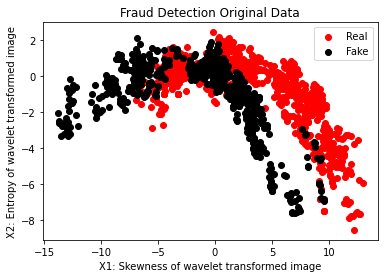

In [10]:
X_real = []
X_fake = []
for i in range(0, X.shape[0]):
    if Y[i] == 0:
        X_real.append(X[i])
    if Y[i] == 1:
        X_fake.append(X[i])
X_real = np.array(X_real)
X_fake = np.array(X_fake)
               
pyplot.scatter(X_real[:,0], X_real[:,1], color='red', label='Real')
pyplot.scatter(X_fake[:,0], X_fake[:,1], color='black',label='Fake')
pyplot.xlabel('X1: Skewness of wavelet transformed image')
pyplot.ylabel('X2: Entropy of wavelet transformed image')
pyplot.title('Fraud Detection Original Data')
pyplot.legend()

As can be seen in the plot above, it is not possible to visually separate the two classes by a straight line.

## 6.2 - Keras + Tensorflow Logistic Regression

In [11]:
model = Sequential([Dense(1, batch_input_shape=(None, 2),activation='sigmoid')])
model.compile(optimizer='sgd', loss='binary_crossentropy', learning_rate=0.15, metrics=['accuracy'])
history = model.fit(X, Y, epochs=400, batch_size=128)

Train on 1372 samples
Epoch 1/400
1372/1372 [==============================] - 0s 349us/sample - loss: 1.5578 - accuracy: 0.3688
Epoch 2/400
1372/1372 [==============================] - 0s 14us/sample - loss: 1.3889 - accuracy: 0.4373
Epoch 3/400
1372/1372 [==============================] - 0s 14us/sample - loss: 1.2829 - accuracy: 0.4818
Epoch 4/400
1372/1372 [==============================] - 0s 15us/sample - loss: 1.2076 - accuracy: 0.4993
Epoch 5/400
1372/1372 [==============================] - 0s 14us/sample - loss: 1.1463 - accuracy: 0.5160
Epoch 6/400
1372/1372 [==============================] - 0s 16us/sample - loss: 1.0939 - accuracy: 0.5248
Epoch 7/400
1372/1372 [==============================] - 0s 17us/sample - loss: 1.0464 - accuracy: 0.5401
Epoch 8/400
1372/1372 [==============================] - 0s 15us/sample - loss: 1.0014 - accuracy: 0.5474
Epoch 9/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.9591 - accuracy: 0.5605
Epoch 10/400
1372/1372 

1372/1372 [==============================] - 0s 16us/sample - loss: 0.5140 - accuracy: 0.7310
Epoch 78/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5140 - accuracy: 0.7303
Epoch 79/400
1372/1372 [==============================] - 0s 14us/sample - loss: 0.5139 - accuracy: 0.7303
Epoch 80/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5138 - accuracy: 0.7303
Epoch 81/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5138 - accuracy: 0.7310
Epoch 82/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5136 - accuracy: 0.7318
Epoch 83/400
1372/1372 [==============================] - 0s 14us/sample - loss: 0.5136 - accuracy: 0.7325
Epoch 84/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5135 - accuracy: 0.7332
Epoch 85/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5134 - accuracy: 0.7318
Epoch 86/400
1372/1372 [==========================

1372/1372 [==============================] - 0s 15us/sample - loss: 0.5116 - accuracy: 0.7128
Epoch 229/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5117 - accuracy: 0.7121
Epoch 230/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5116 - accuracy: 0.7121
Epoch 231/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5116 - accuracy: 0.7128
Epoch 232/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5117 - accuracy: 0.7121
Epoch 233/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5116 - accuracy: 0.7128
Epoch 234/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5115 - accuracy: 0.7121
Epoch 235/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5115 - accuracy: 0.7128
Epoch 236/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5117 - accuracy: 0.7128
Epoch 237/400
1372/1372 [=================

Epoch 304/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5115 - accuracy: 0.7092
Epoch 305/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5116 - accuracy: 0.7092
Epoch 306/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5117 - accuracy: 0.7106
Epoch 307/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5116 - accuracy: 0.7092
Epoch 308/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5116 - accuracy: 0.7092
Epoch 309/400
1372/1372 [==============================] - 0s 17us/sample - loss: 0.5116 - accuracy: 0.7092
Epoch 310/400
1372/1372 [==============================] - 0s 16us/sample - loss: 0.5116 - accuracy: 0.7128
Epoch 311/400
1372/1372 [==============================] - 0s 17us/sample - loss: 0.5115 - accuracy: 0.7114
Epoch 312/400
1372/1372 [==============================] - 0s 15us/sample - loss: 0.5115 - accuracy: 0.7092
Epoch 313/400
1372/1372 [===

Ending accuracy:  0.7084548


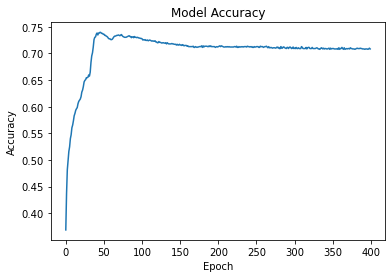

In [14]:
pyplot.plot(history.history['accuracy'])
pyplot.title('Model Accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
print("Ending accuracy: ", history.history['accuracy'][-1])

Text(0.5, 0, 'Epoch')

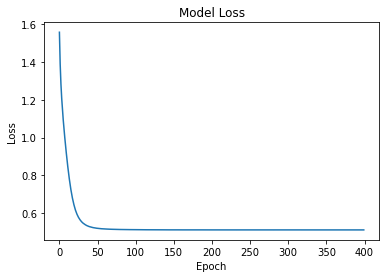

In [13]:
pyplot.plot(history.history['loss'])
pyplot.title('Model Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')

**Question: Is the logistic regresion working well?** <br/> Response: As can be seen from the above graphs, the minimized loss is close to 0 and the resulting accuracy in ~71%. This would be better than linear regression, however this is not a strong accuracy and could likely be improved.

## 6.3 - Visualize

(2500, 2)


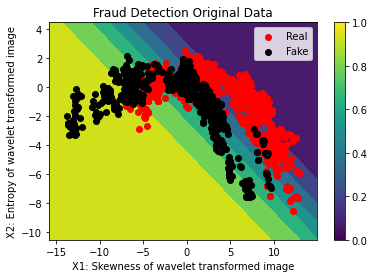

In [15]:
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # Define 50 points on the x1-axis
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # Define 50 points on the x2-axis

x1, x2 = np.meshgrid(x1list, x2list)
x1f = x1.flatten()
x2f = x2.flatten()
vector = np.array([x1f,x2f]).T
print(vector.shape)
pred = model.predict(vector)
pred_r = pred.reshape(50,50)

pyplot.contourf(x1, x2, pred_r);
pyplot.scatter(X_real[:,0], X_real[:,1], color='red', label='Real')
pyplot.scatter(X_fake[:,0], X_fake[:,1], color='black',label='Fake')
pyplot.xlabel('X1: Skewness of wavelet transformed image')
pyplot.ylabel('X2: Entropy of wavelet transformed image')
pyplot.title('Fraud Detection Original Data')
pyplot.legend()
pyplot.colorbar()

**Question: Comment on your observations.** <br/> Response: As can be seen, the model is not very accurate. It is not properly predicting areas of real data (which should be yellow) and areas of fake data (which sould be purple).

## 6.4 - Use Hidden Layer to Improve the Model

In [24]:
# Convert to one-hot encoding
from tensorflow.keras.utils import to_categorical 
Y_c=to_categorical(Y,2)

In [25]:
from tensorflow.keras import layers
model = Sequential([
    layers.Dense(8, batch_input_shape=(None, 2),activation='sigmoid'),
    layers.Dense(2,activation='softmax')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', learning_rate=0.15, metrics=['accuracy'])
history = model.fit(X, Y_c, epochs=400, batch_size=128,verbose=0)

Text(0.5, 0, 'Epoch')

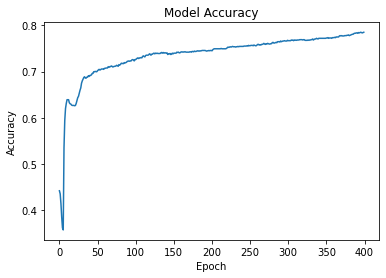

In [26]:
pyplot.plot(history.history['accuracy'])
pyplot.title('Model Accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')

In [27]:
print("Ending accuracy: ", history.history['accuracy'][-1])

Ending accuracy:  0.7849854


Text(0.5, 0, 'Epoch')

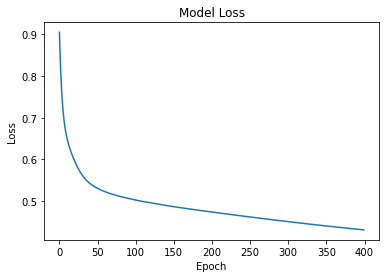

In [28]:
pyplot.plot(history.history['loss'])
pyplot.title('Model Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')

**Question: Comment on your observations.** <br/> As can be seen from the graphs above, the ending acccuracy of the model has increased to ~78%, which is a 7% improvement compared to the neural network with no hidden layer. The loss is also ending close to 0. Therefore, we can conclude that the model has improved.

## 6.5 - Contour Plot of Training with Hidden Layer

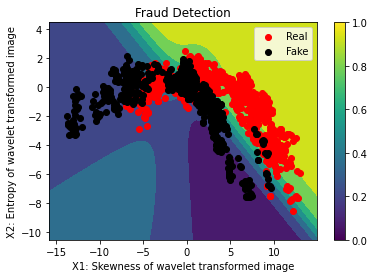

In [29]:
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # Define 50 points on the x1-axis
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # Define 50 points on the x2-axis

x1, x2 = np.meshgrid(x1list, x2list)
x1f = x1.flatten()
x2f = x2.flatten()
vector = np.array([x1f,x2f]).T
prediction = model.predict(vector)
prediction_reshaped = prediction[:,0].reshape(50,50)

pyplot.contourf(x1, x2, prediction_reshaped)
pyplot.scatter(X_real[:,0], X_real[:,1], color='red', label='Real')
pyplot.scatter(X_fake[:,0], X_fake[:,1], color='black',label='Fake')
pyplot.xlabel('X1: Skewness of wavelet transformed image')
pyplot.ylabel('X2: Entropy of wavelet transformed image')
pyplot.title('Fraud Detection')
pyplot.legend()
pyplot.colorbar()

**Question: Comment on your observations.** <br/> Response: As can be seen, the model accuracy has improved. It is better predicting areas of real data as green or yellow and areas of fake data as blue or purple.